# Forecast statistics for Conditional Forecasts

We're headed back into the BVAR python package. This shift in focus was necessaitated by some changes in what was required at what point.

This post deals with the addition of some forecast statistic methods for the conditional forecast routines.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import time
import tempfile
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import GtmmData
import bvar

In [3]:
sns.set_style('whitegrid')
sns.set_palette('deep')

FRED_KEY = os.environ['FRED_KEY']

## Getting the data 

First, let's get the raw output data from a simple conditional forecast. This will serve as a starting point for our summary methods.

In [4]:
def get_forecast_data(force_reload=False):
  save_file = os.path.join(tempfile.gettempdir(), 'bvar-usage', 'apw_forecast_out_data_3var.pkl')
  BASE_PATH = os.path.join(tempfile.gettempdir(), 'bvar-usage')
  BASE_FORECAST_PATH = os.path.join(tempfile.gettempdir(), 'bvar-usage', 'base-forecast')
  
  if not os.path.exists(save_file) or force_reload:
    model_name = '3-var'
    series = ['CPIAUCSL', 'FEDFUNDS', 'PAYEMS']

    model_base_path = os.path.join(BASE_PATH, model_name)
    data_path = os.path.join(model_base_path, 'data.pkl')
    model_path = os.path.join(model_base_path, 'model.pkl')
    if not os.path.exists(model_base_path):
        os.makedirs(model_base_path)

    if not os.path.exists(data_path) or force_reload:
      fred_data0 = GtmmData.FredData(apiKey=FRED_KEY)
      fred_data0.getFredData(ids=series) # Download data
      fred_data0.setTrans(['CPIAUCSL', 'PAYEMS'], 'log') # Make these variables logs
      fred_data = fred_data0.format(balanced=True, freq='coarse',trim=None) # Format it
      fred_data.to_pickle(data_path)
    else:
      fred_data = GtmmData.read_pickle(data_path)

    bvs = bvar.core.BVAR(
      data=fred_data.data,
      lags=13,
      prior_spec='DIO_MN_SOC',
      hyperparameters={'Lambda': 0.75, 'mu': 0.214, 'delta': 0.124, 'dof': 13}
    )

    conditional_forecast_script = '''
    eqn EQ0 = PAYEMS[+1];
    eqn EQ1 = FEDFUNDS[+1];
    eqn EQ2 = FEDFUNDS[+2];

    mean EQ0 = 11.922209936681169; // = log(15074) = Jan. 2019 Nonfarm employment
    mean EQ1 = 2.40; // = Jan 2019 Effective Fed funds rate
    mean EQ2 = 2.38; // Guessing that the fed will not change rates in February => close to constant FFNDs

    std EQ0 = 1e-4;
    std EQ1 = 1e-3;
    std EQ2 = 1e-2;
    '''

    fc = bvs.forecast(
        n_periods = 12,
        kind = 'apw',
        hierarchical = False,
        script = conditional_forecast_script,
        iters = 2000,
        chains = 4
      )

    out = {'bvar': bvs,'in': {'graph': bvs.graph, 'script': fc.script, 'n_periods': fc.n_periods, 'data_labels': fc.data_labels, 'iters': fc.iters}, 'raw_output': fc.raw_output}

    with open(save_file, 'wb') as file:
      pickle.dump(out, file)
    
  else:
    with open(save_file, 'rb') as file:
      out = pickle.load(file)
  
  return out['bvar'], out['in'], out['raw_output']

In [5]:
bvs, forecast_in, raw_output = get_forecast_data(force_reload=False)

In [6]:
print('Shape of Output: {}\nIterations: {}\nn_periods: {}\nVariables: {}'.format(raw_output.shape, forecast_in['iters'], forecast_in['n_periods'], forecast_in['graph'].dims['n']))

Shape of Output: (8000, 36)
Iterations: 8000
n_periods: 12
Variables: 3


So the data is organized so that each draw of the forecast is on the first dimension.

On the second dimension we have `12 * 3 = 36` entries. This is because the sampling for all forecast periods at once.

Let's dive into these 

#### How are the 36 entries on the second dimension organized?

In [7]:
ro = raw_output[0,:]
print('First draw of forecasts:')
print(ro.reshape((-1,3)))
print('As raw data:')
ro

First draw of forecasts:
[[ 5.53577855  2.40074589 11.92212885]
 [ 5.53663863  2.38732433 11.92354695]
 [ 5.53956606  2.01845116 11.92336073]
 [ 5.54318133  2.48250623 11.92674961]
 [ 5.54853988  2.9546312  11.92698642]
 [ 5.55655065  3.43253929 11.93348017]
 [ 5.55897808  3.52571498 11.93396423]
 [ 5.56265915  4.29679042 11.93820151]
 [ 5.56892234  4.2134602  11.94194645]
 [ 5.57749572  4.88721265 11.94607636]
 [ 5.58569359  4.63307617 11.9488183 ]
 [ 5.58988806  4.64769547 11.9533195 ]]
As raw data:


array([ 5.53577855,  2.40074589, 11.92212885,  5.53663863,  2.38732433,
       11.92354695,  5.53956606,  2.01845116, 11.92336073,  5.54318133,
        2.48250623, 11.92674961,  5.54853988,  2.9546312 , 11.92698642,
        5.55655065,  3.43253929, 11.93348017,  5.55897808,  3.52571498,
       11.93396423,  5.56265915,  4.29679042, 11.93820151,  5.56892234,
        4.2134602 , 11.94194645,  5.57749572,  4.88721265, 11.94607636,
        5.58569359,  4.63307617, 11.9488183 ,  5.58988806,  4.64769547,
       11.9533195 ])

It is clear that the data is organized as:

$$
\underbrace{CPIAUCSL_{+1}, FEDFUNDS_{+1}, PAYEMS_{+1}}_{\text{Forecast Period 1}}\dots\underbrace{CPIAUCSL_{+n}, FEDFUNDS_{+n}, PAYEMS_{+n}}_{\text{Forecast Period } n\_periods}
$$

## Goals for the methods

We anticipate creating two main methods:

- `tabletable(self, cols: [list, None] = None, forecast_periods: [int, None] = None, data_periods: [int, None] = 0, as_frame: bool = False, mark_forecast: bool = True, percentiles: [list, np.ndarray, None] = [0.33, 0.66], median:bool=True, mean: bool = True, std: bool = True )`. Will output a pandas dataframe containing a 
- `plot()`. Will output a set of plots containing "fan plots" of predictions along with lines for the median and mean.

This means that the main steps will be:

1. Compute relevant summary statistics
1. Reshape the data to an order amenable to the 

### Relevant Summary Statistics

Here we can draw upon the relevant numpy methods/functions.

The only thing to check is that we compute along the correct dimensions. Try `axis=0`.

In [8]:
on_axis = 0
s0 = np.mean(raw_output, axis=on_axis).shape[0]
assert s0 == raw_output.shape[1]
print('Shape of output when `axis={}`: {}'.format(on_axis, s0))

Shape of output when `axis=0`: 36


#### Mean, Median, and Standard deviation

In [9]:
mean_ = raw_output.mean(axis=0)
std_ = raw_output.std(axis=0)

In [10]:
assert mean_.shape[0] == raw_output.shape[1]
assert std_.shape[0] == raw_output.shape[1]

#### Quantiles

Will have arguments in which bands are specified and can include the median or not:

In [11]:
bands_ = [0.33, 0.5]
median_ = True

##### Construct the bands to be computed

In [12]:
def get_q_in(bands, median):
  q_in = [0.5 + sgn * (b * 0.5) for b in bands for sgn in [-1, 1]]
  if median: q_in.append(0.5)
  return q_in

In [13]:
assert get_q_in([0.33, 0.5], True) == [0.5-0.33*0.5, 0.5+0.33*0.5,0.5-0.5*0.5, 0.5+0.5*0.5, 0.5]
assert get_q_in([0.33, 0.5], False) == [0.5-0.33*0.5, 0.5+0.33*0.5,0.5-0.5*0.5, 0.5+0.5*0.5]
assert get_q_in([0.33], True) == [0.5-0.33*0.5, 0.5+0.33*0.5, 0.5]
assert get_q_in([0.33, 0.5, 0.75], True) == [0.5-0.33*0.5, 0.5+0.33*0.5,0.5-0.5*0.5, 0.5+0.5*0.5,0.5-0.75*0.5, 0.5+0.75*0.5, 0.5]

##### Compute the quantiles

In [14]:
q_in = get_q_in(bands_, median_)
q_out = np.quantile(a=raw_output, q=q_in, axis=0)

##### Deconstruct the quantiles

For tables we'll want one thing. For plots we'll want another. So this is where the paths split.

### Formatting `table` output

Let's focus first on how we'll deal with the mean and standard deviations:

In [15]:
n = forecast_in['graph'].dims['n']
n_periods = forecast_in['n_periods']
cols = forecast_in['data_labels'].cols
stats = []
data = np.ndarray((n_periods,0))

In [16]:
nm = 'Mean'
attr = 'mean'

st = getattr(raw_output, attr)(axis=0)
st = st.reshape((n_periods,n))
stats.append(nm)
data = np.hstack((data, st))
st

array([[  5.70721221,   2.39999033,  11.92221075],
       [  5.67557832,   2.37990108,  11.96587449],
       [  5.63199018, -14.50868911,  12.12897998],
       [  5.68957728, -56.07958272,  12.26641661],
       [  5.79783285, -46.42008304,  12.38040558],
       [  5.73362324, -53.18859906,  12.46557087],
       [  5.61249023, -59.90872291,  12.47028317],
       [  5.36017587, -79.33356175,  12.41577415],
       [  5.24275286, -59.16609078,  12.4192543 ],
       [  5.1271327 , -50.07695708,  12.46742987],
       [  5.0571483 , -32.10243844,  12.39888329],
       [  4.8291882 , -53.66869764,  12.29923084]])

In [17]:
nm = 'SD'
attr = 'std'

st = getattr(raw_output, attr)(axis=0)
st = st.reshape((n_periods,n))
stats.append(nm)
data = np.hstack((data, st))
st

array([[1.01172305e+01, 1.00368167e-03, 9.92876007e-05],
       [1.73035714e+01, 1.00555872e-02, 8.54769088e+00],
       [2.32156313e+01, 2.01147629e+03, 1.30824381e+01],
       [2.83302432e+01, 3.35235516e+03, 1.87308569e+01],
       [3.34583214e+01, 4.28103716e+03, 2.45417029e+01],
       [3.85999408e+01, 4.97732190e+03, 3.05314260e+01],
       [4.35485239e+01, 5.48760891e+03, 3.67346647e+01],
       [4.89206741e+01, 5.94557311e+03, 4.30451659e+01],
       [5.43287635e+01, 6.33154650e+03, 4.93692309e+01],
       [5.97375666e+01, 6.64120471e+03, 5.56463540e+01],
       [6.55321352e+01, 7.02194459e+03, 6.20609618e+01],
       [7.19828695e+01, 7.49598432e+03, 6.84019070e+01]])

In [18]:
idx = pd.MultiIndex.from_product([stats,cols])
idx.tolist()

[('Mean', 'CPIAUCSL'),
 ('Mean', 'FEDFUNDS'),
 ('Mean', 'PAYEMS'),
 ('SD', 'CPIAUCSL'),
 ('SD', 'FEDFUNDS'),
 ('SD', 'PAYEMS')]

In [19]:
df = pd.DataFrame(data, columns=idx).reorder_levels([1, 0], axis=1).sort_index(level=0, axis=1)

df

CPIAUCSL              FEDFUNDS                  PAYEMS           
        Mean         SD       Mean           SD       Mean         SD
0   5.707212  10.117230   2.399990     0.001004  11.922211   0.000099
1   5.675578  17.303571   2.379901     0.010056  11.965874   8.547691
2   5.631990  23.215631 -14.508689  2011.476294  12.128980  13.082438
3   5.689577  28.330243 -56.079583  3352.355161  12.266417  18.730857
4   5.797833  33.458321 -46.420083  4281.037157  12.380406  24.541703
5   5.733623  38.599941 -53.188599  4977.321898  12.465571  30.531426
6   5.612490  43.548524 -59.908723  5487.608913  12.470283  36.734665
7   5.360176  48.920674 -79.333562  5945.573105  12.415774  43.045166
8   5.242753  54.328764 -59.166091  6331.546497  12.419254  49.369231
9   5.127133  59.737567 -50.076957  6641.204709  12.467430  55.646354
10  5.057148  65.532135 -32.102438  7021.944586  12.398883  62.060962
11  4.829188  71.982870 -53.668698  7495.984319  12.299231  68.401907

Now let's add on the quantiles. The big question is how we should deal with indexing.

In [20]:
q_in = get_q_in(bands_, median_)
q_out = np.quantile(a=raw_output, q=q_in, axis=0)

Now sort the outputs according to their percentile:

In [21]:
q_in2 = np.array(q_in)
nq = len(q_in)

idx = q_in2.argsort()
print(idx)
print(q_in2[idx])

[2 0 4 1 3]
[0.25  0.335 0.5   0.665 0.75 ]


Reshaping so that the output has the form:

$$
\underbrace{CPIAUCSL_{+1}^{q=0.25},\;CPIAUCSL_{+1}^{q=0.33},\;CPIAUCSL_{+1}^{q=0.50}\;CPIAUCSL_{+1}^{q=0.66},\;CPIAUCSL_{+1}^{q=0.75}}_{\text{CPIAUCSL Quantiles, Forecast period 1}}\dots\underbrace{FEDFUNDS_{+1}^{q=0.25},\dots\;FEDFUNDS_{+1}^{q=0.75}}_{\text{FEDFUNDS Quantiles, Forecast period 1}}\\
\dots\\
\dots\\
\underbrace{CPIAUCSL_{+n}^{q=0.25},\;CPIAUCSL_{+n}^{q=0.33},\;CPIAUCSL_{+n}^{q=0.50}\;CPIAUCSL_{+n}^{q=0.66},\;CPIAUCSL_{+n}^{q=0.75}}_{\text{CPIAUCSL Quantiles, Forecast period n}}\dots\underbrace{FEDFUNDS_{+n}^{q=0.25},\dots\;FEDFUNDS_{+n}^{q=0.75}}_{\text{FEDFUNDS Quantiles, Forecast period n}}
$$

In [22]:
q_ = q_out[idx].T.reshape((n_periods, nq*n))
print(q_.shape)
print(q_[:, 0])

(12, 15)
[  1.17208259  -2.29941553  -5.0232536   -7.40810138  -9.17605245
 -11.90376668 -14.4541255  -17.47721756 -19.53937689 -21.78950252
 -24.33079202 -27.36574052]


In [23]:
q_in.sort()
q_names = ['Q{}'.format(int(100*ii)) for ii in q_in]
idx = pd.MultiIndex.from_product([cols, q_names])
idx.tolist()

[('CPIAUCSL', 'Q25'),
 ('CPIAUCSL', 'Q33'),
 ('CPIAUCSL', 'Q50'),
 ('CPIAUCSL', 'Q66'),
 ('CPIAUCSL', 'Q75'),
 ('FEDFUNDS', 'Q25'),
 ('FEDFUNDS', 'Q33'),
 ('FEDFUNDS', 'Q50'),
 ('FEDFUNDS', 'Q66'),
 ('FEDFUNDS', 'Q75'),
 ('PAYEMS', 'Q25'),
 ('PAYEMS', 'Q33'),
 ('PAYEMS', 'Q50'),
 ('PAYEMS', 'Q66'),
 ('PAYEMS', 'Q75')]

In [24]:
dfq = pd.DataFrame(q_, columns=idx)
dfq.head()

CPIAUCSL                                               FEDFUNDS  \
        Q25       Q33       Q50        Q66        Q75          Q25   
0  1.172083  3.255864  5.558596   7.928439  10.067418     2.399308   
1 -2.299416  1.452746  5.536937   9.636654  13.440512     2.372967   
2 -5.023254 -0.107650  5.528989  11.066792  16.249108  -892.573838   
3 -7.408101 -1.351461  5.535262  12.247859  18.235584 -1564.614533   
4 -9.176052 -2.401746  5.453769  13.551090  21.096778 -2029.456295   

                                                        PAYEMS             \
           Q33        Q50          Q66          Q75        Q25        Q33   
0     2.399554   2.399970     2.400433     2.400678  11.922143  11.922168   
1     2.375524   2.379754     2.384346     2.386725   8.169222  10.012062   
2  -463.990003   0.385163   455.700275   878.911284   6.291760   8.992019   
3  -814.078229 -20.495660   767.086656  1430.779292   3.856204   7.887660   
4 -1058.992613 -14.517050  1016.400988  1953.515688   1.423861   6.388739   

                                    
         Q50        Q66        Q75  
0  11.922211  11.922253  11.922276  
1  11.925857  13.933985  15.718575  
2  11.957307  15.069844  17.875194  
3  11.999705  16.458467  20.629071  
4  11.996967  17.937816  23.208634

In [25]:
df = df.merge(dfq,left_index=True, right_index=True).sort_index(level=0, axis=1)
df.head()

CPIAUCSL                                                                 \
       Mean       Q25       Q33       Q50        Q66        Q75         SD   
0  5.707212  1.172083  3.255864  5.558596   7.928439  10.067418  10.117230   
1  5.675578 -2.299416  1.452746  5.536937   9.636654  13.440512  17.303571   
2  5.631990 -5.023254 -0.107650  5.528989  11.066792  16.249108  23.215631   
3  5.689577 -7.408101 -1.351461  5.535262  12.247859  18.235584  28.330243   
4  5.797833 -9.176052 -2.401746  5.453769  13.551090  21.096778  33.458321   

    FEDFUNDS                              ...                                \
        Mean          Q25          Q33    ...              Q66          Q75   
0   2.399990     2.399308     2.399554    ...         2.400433     2.400678   
1   2.379901     2.372967     2.375524    ...         2.384346     2.386725   
2 -14.508689  -892.573838  -463.990003    ...       455.700275   878.911284   
3 -56.079583 -1564.614533  -814.078229    ...       767.086656  1430.779292   
4 -46.420083 -2029.456295 -1058.992613    ...      1016.400988  1953.515688   

                   PAYEMS                                              \
            SD       Mean        Q25        Q33        Q50        Q66   
0     0.001004  11.922211  11.922143  11.922168  11.922211  11.922253   
1     0.010056  11.965874   8.169222  10.012062  11.925857  13.933985   
2  2011.476294  12.128980   6.291760   8.992019  11.957307  15.069844   
3  3352.355161  12.266417   3.856204   7.887660  11.999705  16.458467   
4  4281.037157  12.380406   1.423861   6.388739  11.996967  17.937816   

                         
         Q75         SD  
0  11.922276   0.000099  
1  15.718575   8.547691  
2  17.875194  13.082438  
3  20.629071  18.730857  
4  23.208634  24.541703  

[5 rows x 21 columns]

##### Adding on non-forecast data

In [51]:
apw = bvar.core.Forecast.ApwNonHier(**forecast_in, auto_run=False)

mark_forecast = True
data_periods = 5

In [41]:
ncol = df.columns.shape[0]
dpt = np.tile(apw.data[-data_periods:, ], (1,ncol//n))

In [43]:
print(apw.data[-data_periods:,:])
print(dpt.shape)
print(dpt)

[[ 5.52881779  1.91       11.91483091]
 [ 5.52940528  1.95       11.91555322]
 [ 5.53270546  2.19       11.91740342]
 [ 5.53289925  2.2        11.91871052]
 [ 5.5323336   2.27       11.92018896]]
(5, 21)
[[ 5.52881779  1.91       11.91483091  5.52881779  1.91       11.91483091
   5.52881779  1.91       11.91483091  5.52881779  1.91       11.91483091
   5.52881779  1.91       11.91483091  5.52881779  1.91       11.91483091
   5.52881779  1.91       11.91483091]
 [ 5.52940528  1.95       11.91555322  5.52940528  1.95       11.91555322
   5.52940528  1.95       11.91555322  5.52940528  1.95       11.91555322
   5.52940528  1.95       11.91555322  5.52940528  1.95       11.91555322
   5.52940528  1.95       11.91555322]
 [ 5.53270546  2.19       11.91740342  5.53270546  2.19       11.91740342
   5.53270546  2.19       11.91740342  5.53270546  2.19       11.91740342
   5.53270546  2.19       11.91740342  5.53270546  2.19       11.91740342
   5.53270546  2.19       11.91740342]
 [ 5.53289925

In [53]:
dfdp = pd.DataFrame(dpt, columns=df.sort_index(level=1, axis=1).columns).sort_index(level=0, axis=1)
if mark_forecast:
  dfdp['forecast'] = False

dfdp

CPIAUCSL                                                              \
       Mean       Q25       Q33       Q50       Q66       Q75        SD   
0  5.528818  5.528818  5.528818  5.528818  5.528818  5.528818  5.528818   
1  5.529405  5.529405  5.529405  5.529405  5.529405  5.529405  5.529405   
2  5.532705  5.532705  5.532705  5.532705  5.532705  5.532705  5.532705   
3  5.532899  5.532899  5.532899  5.532899  5.532899  5.532899  5.532899   
4  5.532334  5.532334  5.532334  5.532334  5.532334  5.532334  5.532334   

  FEDFUNDS               ...                    PAYEMS                        \
      Mean   Q25   Q33   ...      Q75    SD       Mean        Q25        Q33   
0     1.91  1.91  1.91   ...     1.91  1.91  11.914831  11.914831  11.914831   
1     1.95  1.95  1.95   ...     1.95  1.95  11.915553  11.915553  11.915553   
2     2.19  2.19  2.19   ...     2.19  2.19  11.917403  11.917403  11.917403   
3     2.20  2.20  2.20   ...     2.20  2.20  11.918711  11.918711  11.918711   
4     2.27  2.27  2.27   ...     2.27  2.27  11.920189  11.920189  11.920189   

                                              forecast  
         Q50        Q66        Q75         SD           
0  11.914831  11.914831  11.914831  11.914831    False  
1  11.915553  11.915553  11.915553  11.915553    False  
2  11.917403  11.917403  11.917403  11.917403    False  
3  11.918711  11.918711  11.918711  11.918711    False  
4  11.920189  11.920189  11.920189  11.920189    False  

[5 rows x 22 columns]

In [50]:
df = dfdp.append(df)

CPIAUCSL                                                                   \
        Mean        Q25        Q33       Q50        Q66        Q75         SD   
0   5.528818   5.528818   5.528818  5.528818   5.528818   5.528818   5.528818   
1   5.529405   5.529405   5.529405  5.529405   5.529405   5.529405   5.529405   
2   5.532705   5.532705   5.532705  5.532705   5.532705   5.532705   5.532705   
3   5.532899   5.532899   5.532899  5.532899   5.532899   5.532899   5.532899   
4   5.532334   5.532334   5.532334  5.532334   5.532334   5.532334   5.532334   
0   5.707212   1.172083   3.255864  5.558596   7.928439  10.067418  10.117230   
1   5.675578  -2.299416   1.452746  5.536937   9.636654  13.440512  17.303571   
2   5.631990  -5.023254  -0.107650  5.528989  11.066792  16.249108  23.215631   
3   5.689577  -7.408101  -1.351461  5.535262  12.247859  18.235584  28.330243   
4   5.797833  -9.176052  -2.401746  5.453769  13.551090  21.096778  33.458321   
5   5.733623 -11.903767  -3.684431  5.567625  14.716477  23.217721  38.599941   
6   5.612490 -14.454126  -4.902189  5.564304  15.824323  25.411144  43.548524   
7   5.360176 -17.477218  -5.830665  5.553535  16.669613  27.517259  48.920674   
8   5.242753 -19.539377  -7.397520  5.408567  17.670460  29.345825  54.328764   
9   5.127133 -21.789503  -8.506820  5.351236  18.790861  31.893342  59.737567   
10  5.057148 -24.330792  -9.962632  5.350453  20.247088  34.356659  65.532135   
11  4.829188 -27.365741 -11.997578  5.051936  21.841271  36.963271  71.982870   

     FEDFUNDS                              ...                                \
         Mean          Q25          Q33    ...              Q66          Q75   
0    1.910000     1.910000     1.910000    ...         1.910000     1.910000   
1    1.950000     1.950000     1.950000    ...         1.950000     1.950000   
2    2.190000     2.190000     2.190000    ...         2.190000     2.190000   
3    2.200000     2.200000     2.200000    ...         2.200000     2.200000   
4    2.270000     2.270000     2.270000    ...         2.270000     2.270000   
0    2.399990     2.399308     2.399554    ...         2.400433     2.400678   
1    2.379901     2.372967     2.375524    ...         2.384346     2.386725   
2  -14.508689  -892.573838  -463.990003    ...       455.700275   878.911284   
3  -56.079583 -1564.614533  -814.078229    ...       767.086656  1430.779292   
4  -46.420083 -2029.456295 -1058.992613    ...      1016.400988  1953.515688   
5  -53.188599 -2324.803750 -1231.043872    ...      1129.052660  2199.907159   
6  -59.908723 -2587.775501 -1336.282936    ...      1255.346664  2343.916026   
7  -79.333562 -2789.683881 -1452.820458    ...      1341.349599  2545.289708   
8  -59.166091 -2915.125041 -1497.389673    ...      1410.912662  2724.453543   
9  -50.076957 -3056.428636 -1570.765072    ...      1444.615619  3009.178347   
10 -32.102438 -3095.738778 -1680.360192    ...      1598.822315  3170.583072   
11 -53.668698 -3342.712329 -1751.054245    ...      1718.287098  3382.741609   

                    PAYEMS                                              \
             SD       Mean        Q25        Q33        Q50        Q66   
0      1.910000  11.914831  11.914831  11.914831  11.914831  11.914831   
1      1.950000  11.915553  11.915553  11.915553  11.915553  11.915553   
2      2.190000  11.917403  11.917403  11.917403  11.917403  11.917403   
3      2.200000  11.918711  11.918711  11.918711  11.918711  11.918711   
4      2.270000  11.920189  11.920189  11.920189  11.920189  11.920189   
0      0.001004  11.922211  11.922143  11.922168  11.922211  11.922253   
1      0.010056  11.965874   8.169222  10.012062  11.925857  13.933985   
2   2011.476294  12.128980   6.291760   8.992019  11.957307  15.069844   
3   3352.355161  12.266417   3.856204   7.887660  11.999705  16.458467   
4   4281.037157  12.380406   1.423861   6.388739  11.996967  17.937816   
5   4977.321898  12.465571  -1.180717   4.926950  11.95

### Creating the `plot` method


Basically, we want to plot 


Other things to consider:

- Passing in plot keyword arguments
    - `figsize`
    - `sharex`
    - `sharey`
- Figuring out appropriate number of columns
- Figuring out appropriate colors.

In [217]:
cols = forecast_in['data_labels'].cols
plot_kwds = {}
bands = [0.1, 0.33]
median = True
mean = True
set_title = True
area_alpha = 0.1
annotate = True
data_periods = 10
forecast_periods = None
area_color = sns.palettes.SEABORN_PALETTES['deep'][0]
data_color = sns.palettes.SEABORN_PALETTES['deep'][1]
median_color = sns.palettes.SEABORN_PALETTES['deep'][1]
mean_color = sns.palettes.SEABORN_PALETTES['deep'][2]
col_wrap = 3

### Plot the quantiles

Get the quantiles

In [208]:
q_in = get_q_in(bands, median)
q_out = np.quantile(a=raw_output, q=q_in, axis=0)

Split out into separate parts:

In [209]:
q_ = [q_out[ii:ii+2] for ii in range(0, 2*len(bands), 2)]
if median:
  med = q_out[-1]
  
print(len(q_), [qq.shape for qq in q_], med.shape)

2 [(2, 36), (2, 36)] (36,)


Reshape into separate parts:

In [210]:
def reshape_qq(qq):
  return qq.reshape(( 2,n_periods, n)).transpose((0,2,1))

q_ = [reshape_qq(q_out[ii:ii+2]) for ii in range(0, 2*len(bands), 2)]
if median:
  med = q_out[-1].reshape(n_periods, n).T

In [211]:
q_[0][0], med

(array([[   5.1097132 ,    4.74977698,    4.38086944,    4.20981301,
            3.97540915,    3.89396301,    3.45618083,    3.13738584,
            2.6655581 ,    2.26376318,    2.00498706,    1.45623779],
        [   2.39984784,    2.37846443,  -91.18489127, -190.43841039,
         -231.88337593, -269.17183834, -260.67927284, -316.23350249,
         -340.7199368 , -376.16232931, -356.41951608, -388.21643114],
        [  11.92219768,   11.53356568,   11.41086351,   11.2012006 ,
           10.96308575,   10.55493791,   10.10469349,    9.65541763,
            9.23002853,    9.01880677,    8.79279093,    8.69927307]]),
 array([[  5.55859631,   5.53693683,   5.52898862,   5.5352621 ,
           5.45376882,   5.56762533,   5.56430445,   5.55353481,
           5.40856667,   5.35123571,   5.35045316,   5.05193626],
        [  2.39996993,   2.37975434,   0.38516342, -20.49566014,
         -14.51704993, -11.06057472,  -1.32471267, -13.89784951,
         -18.78740355, -16.22127349, -18.9385643

#### Get the mean

In [212]:
avg = raw_output.mean(axis=0).reshape((n_periods,n)).T

In [213]:
avg[0]

array([5.70721221, 5.67557832, 5.63199018, 5.68957728, 5.79783285,
       5.73362324, 5.61249023, 5.36017587, 5.24275286, 5.1271327 ,
       5.0571483 , 4.8291882 ])

#### Plot it all

In [214]:
import warnings

if data_periods is not None and data_periods > 0:
  dp = apw.data[-data_periods:].T

if forecast_periods is None:
  fp = n_periods+1
elif forecast_periods > n_periods:
  warnings.warn(
          'Asked for {0:} periods but only forecasted {1:} in the future. Returning forecasts for {1:} periods'
          .format(forecast_periods, n_periods)
        )
  fp = n_periods+1
elif forecast_periods < 1:
  warnings.warn(
          'Asked for {0:} but this should be >= 1. Forecasting 1 period.'
          .format(forecast_periods)
        )
  fp = 1
else:
  fp = forecast_periods

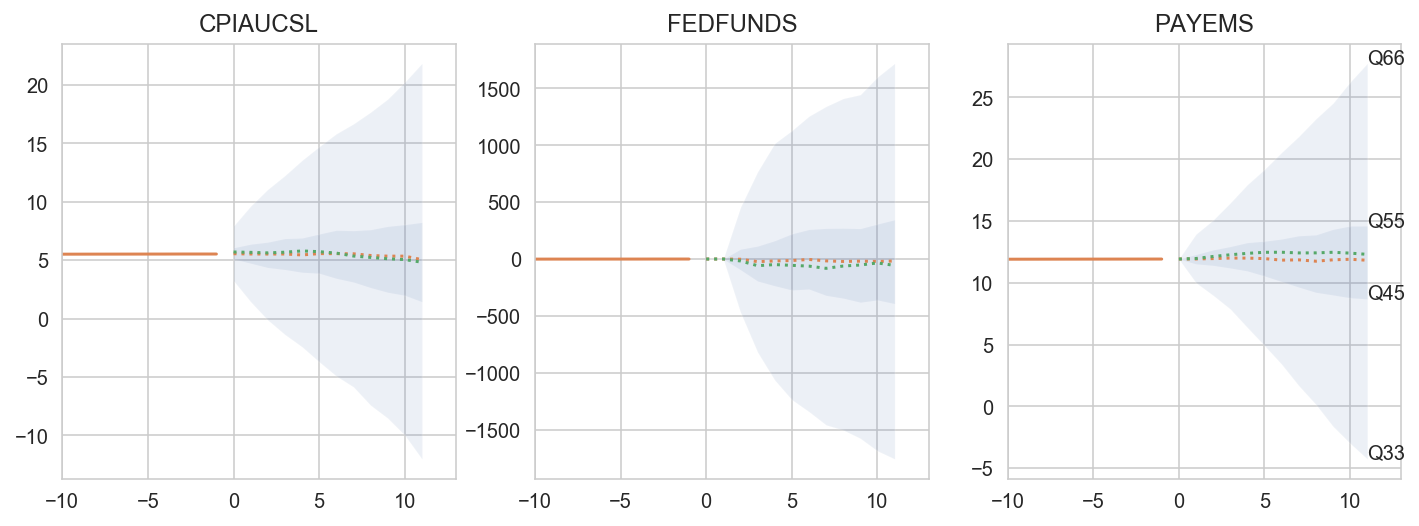

In [215]:
fig, axes = plt.subplots(1,len(cols), sharex=False, sharey=False, figsize=(12,4))
axes = axes.flatten()

xr = np.arange(0,fp-1,1)
for ii,ax in enumerate(axes):

  for jj in range(len(q_)):
    ax.fill_between(x=xr, y1=q_[jj][0][ii,:fp], y2=q_[jj][1][ii,:fp], alpha=area_alpha, facecolor=area_color)

  if median:
    ax.plot(xr, med[ii], ls=':', color=median_color)
  if mean:
    ax.plot(xr, avg[ii], ls=':', color=mean_color)
  if dp is not None:
    ax.set_xlim((-data_periods, fp))
    ax.plot(np.arange(-data_periods,0), dp[ii], ls='-', color=data_color)
  if set_title:
    ax.set_title(cols[ii])
    
if annotate:
  ax = axes[-1]
  q_in2 = [q_in[ii:ii+2] for ii in range(0, 2*len(bands), 2)]
  for jj,qq in enumerate(q_in2):
    for ii in range(2):
      ax.annotate('Q{}'.format(int(100*qq[ii])), xy=(xr[-1], q_[jj][ii][-1][-1]), xytext=(xr[-1], q_[jj][ii][-1][-1]))

## Testing out the methods

In [235]:
apw = bvar.core.Forecast.ApwNonHier(**forecast_in, auto_run=False)
apw.raw_output = raw_output

In [73]:
apw.table(cols=None, data_periods=2, forecast_periods=10, bands=[0.5,0.45])

(2, 21) 21 7 (2, 3)


CPIAUCSL                                                                   \
       Mean        Q25        Q27       Q50        Q72        Q75         SD   
0  5.532899   5.532899   5.532899  5.532899   5.532899   5.532899   5.532899   
1  5.532334   5.532334   5.532334  5.532334   5.532334   5.532334   5.532334   
0  5.707212   1.172083   1.820161  5.558596   9.374341  10.067418  10.117230   
1  5.675578  -2.299416  -0.996630  5.536937  12.165938  13.440512  17.303571   
2  5.631990  -5.023254  -3.363592  5.528989  14.735267  16.249108  23.215631   
3  5.689577  -7.408101  -5.257462  5.535262  16.450543  18.235584  28.330243   
4  5.797833  -9.176052  -6.762024  5.453769  18.703658  21.096778  33.458321   
5  5.733623 -11.903767  -9.154052  5.567625  20.169185  23.217721  38.599941   
6  5.612490 -14.454126 -11.339495  5.564304  22.089155  25.411144  43.548524   
7  5.360176 -17.477218 -13.556761  5.553535  23.893229  27.517259  48.920674   
8  5.242753 -19.539377 -15.554052  5.408567  25.742955  29.345825  54.328764   
9  5.127133 -21.789503 -17.052993  5.351236  27.205881  31.893342  59.737567   

    FEDFUNDS                             ...                               \
        Mean          Q25          Q27   ...             Q75           SD   
0   2.200000     2.200000     2.200000   ...        2.200000     2.200000   
1   2.270000     2.270000     2.270000   ...        2.270000     2.270000   
0   2.399990     2.399308     2.399384   ...        2.400678     0.001004   
1   2.379901     2.372967     2.373805   ...        2.386725     0.010056   
2 -14.508689  -892.573838  -745.142456   ...      878.911284  2011.476294   
3 -56.079583 -1564.614533 -1326.535506   ...     1430.779292  3352.355161   
4 -46.420083 -2029.456295 -1690.783469   ...     1953.515688  4281.037157   
5 -53.188599 -2324.803750 -1926.215822   ...     2199.907159  4977.321898   
6 -59.908723 -2587.775501 -2197.875587   ...     2343.916026  5487.608913   
7 -79.333562 -2789.683881 -2360.669968   ...     2545.289708  5945.573105   
8 -59.166091 -2915.125041 -2427.564806   ...     2724.453543  6331.546497   
9 -50.076957 -3056.428636 -2567.727690   ...     3009.178347  6641.204709   

      PAYEMS                                                         \
        Mean        Q25        Q27        Q50        Q72        Q75   
0  11.918711  11.918711  11.918711  11.918711  11.918711  11.918711   
1  11.920189  11.920189  11.920189  11.920189  11.920189  11.920189   
0  11.922211  11.922143  11.922151  11.922211  11.922268  11.922276   
1  11.965874   8.169222   8.797250  11.925857  15.095541  15.718575   
2  12.128980   6.291760   7.275517  11.957307  16.929321  17.875194   
3  12.266417   3.856204   5.207960  11.999705  19.187021  20.629071   
4  12.380406   1.423861   3.051905  11.996967  21.370389  23.208634   
5  12.465571  -1.180717   0.652790  11.955524  23.616410  25.792445   
6  12.470283  -4.265732  -1.839271  11.832529  25.880526  28.638489   
7  12.415774  -7.125921  -4.270124  11.855014  28.375590  31.687125   
8  12.419254 -10.170956  -6.827457  11.745662  31.041344  34.639018   
9  12.467430 -12.734445  -9.017099  11.856743  33.629562  37.913466   

             forecast  
          SD           
0  11.918711    False  
1  11.920189    False  
0   0.000099     True  
1   8.547691     True  
2  13.082438     True  
3  18.730857     True  
4  24.541703     True  
5  30.531426     True  
6  36.734665     True  
7  43.045166     True  
8  49.369231     True  
9  55.646354     True  

[12 rows x 22 columns]

In [75]:
apw.table(cols=['FEDFUNDS'], data_periods=None, forecast_periods=10, bands=[0.5])

FEDFUNDS                                                   forecast
        Mean          Q25        Q50          Q75           SD         
0   2.399990     2.399308   2.399970     2.400678     0.001004        1
1   2.379901     2.372967   2.379754     2.386725     0.010056        1
2 -14.508689  -892.573838   0.385163   878.911284  2011.476294        1
3 -56.079583 -1564.614533 -20.495660  1430.779292  3352.355161        1
4 -46.420083 -2029.456295 -14.517050  1953.515688  4281.037157        1
5 -53.188599 -2324.803750 -11.060575  2199.907159  4977.321898        1
6 -59.908723 -2587.775501  -1.324713  2343.916026  5487.608913        1
7 -79.333562 -2789.683881 -13.897850  2545.289708  5945.573105        1
8 -59.166091 -2915.125041 -18.787404  2724.453543  6331.546497        1
9 -50.076957 -3056.428636 -16.221273  3009.178347  6641.204709        1

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000012CBFA20>,
        None], dtype=object))

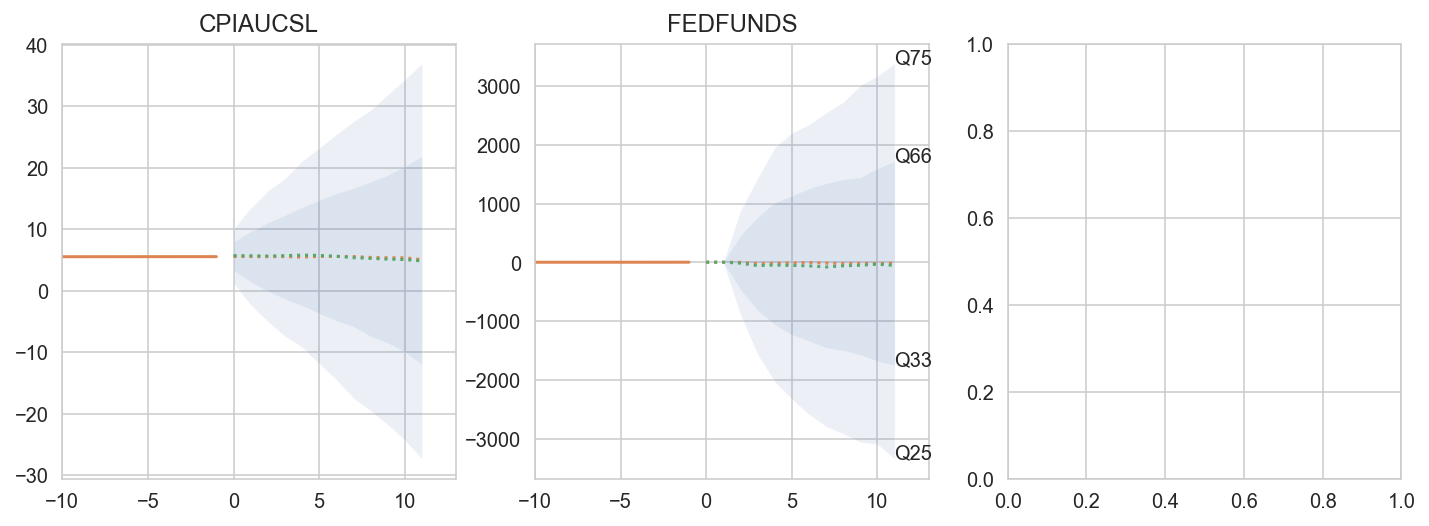

In [247]:
apw.plot(cols=['FEDFUNDS', 'CPIAUCSL'], data_periods=10)